In [1]:
%load_ext tikzmagic
%matplotlib inline

# 모형 선택과 과최적화

이제 모형의 성능을 비교할 수 있으므로 남은 문제는 여러가지 선형회귀모형을 분석하여 가장 좋은 모형을 찾는 일이다. 이를 <b>모형 선택(model selection)</b>이라고 한다. 선형회귀분석에서는 어떤 독립변수를 사용하는가에 따라 회귀모형이 달라지므로 이를 <b>변수 선택(variable selection)</b>이고 하기도 한다.

선형회귀분석에서 변수 선택을 하는 방법은 여러가지가 있다. 모든 변수의 선택 조합에 대해 성능을 살펴보는 것은 독립변수의 개수가 많을 경우 현실적으로 어렵기 때문에 보통은 다음 두 가지 접근방식을 많이 사용한다. 

* 전진 선택(forward selection) : 독립변수가 적은 간단한 모형부터 시작하여 차츰 유의한 독립변수를 추가하는 방식
* 후진 제거(backward elimination) : 모든 독립변수를 사용한 가장 복잡한 모형부터 시작하여 차츰 유의하지 않은 독립변수를 제거하는 방식

이 절에서는 보스턴 집값 데이터를 예로 사용하여 순방향 선택 방법에 대해서만 설명한다.

In [2]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


일단 하나의 독립변수만 사용한 모형을 비교해보자. 보스턴 집값 데이터에는 13개의 독립변수가 있으므로 13개의 모형이 만들어진다.

In [3]:
import statsmodels.api as sm

models_1 = {
    "model_1_crim": sm.OLS.from_formula("medv ~ scale(crim)", boston),
    "model_1_zn": sm.OLS.from_formula("medv ~ scale(zn)", boston),
    "model_1_indus": sm.OLS.from_formula("medv ~ scale(indus)", boston),
    "model_1_chas": sm.OLS.from_formula("medv ~ C(chas)", boston),
    "model_1_nox": sm.OLS.from_formula("medv ~ scale(nox)", boston),
    "model_1_rm": sm.OLS.from_formula("medv ~ scale(rm)", boston),
    "model_1_age": sm.OLS.from_formula("medv ~ scale(age)", boston),
    "model_1_dis": sm.OLS.from_formula("medv ~ scale(dis)", boston),
    "model_1_rad": sm.OLS.from_formula("medv ~ scale(rad)", boston),
    "model_1_tax": sm.OLS.from_formula("medv ~ scale(tax)", boston),
    "model_1_ptratio": sm.OLS.from_formula("medv ~ scale(ptratio)", boston),
    "model_1_black": sm.OLS.from_formula("medv ~ scale(black)", boston),
    "model_1_lstat": sm.OLS.from_formula("medv ~ scale(lstat)", boston),
}

이 모형들에 대해 회귀분석을 실시하여 결과 객체를 얻는다.

In [4]:
results_1 = {}
for model_name, model in models_1.items():
    results_1[model_name] = model.fit()

모형 선택을 할 때도 여러가지를 고려할 수 있지만 여기에서는 결정계수 $R^2$로 대표되는 예측성능만 고려하기로 한다. 위에서 구한 13가지 모형의 결정계수를 구하면 다음과 같다.

In [5]:
import pandas as pd

df_1 = pd.DataFrame({
  "r2": {n: r.rsquared for n, r in results_1.items()},
})
df_1.sort_values("r2", ascending=False)

,r2
model_1_lstat,0.544146
model_1_rm,0.483525
model_1_ptratio,0.257847
model_1_indus,0.233990
model_1_tax,0.219526
model_1_nox,0.182603
model_1_crim,0.150780
model_1_rad,0.145639
model_1_age,0.142095
model_1_zn,0.129921


13가지 모형 중 lstat을 독립변수로 사용한 모형의 결정계수값이 0.54로 가장 결정계수가 높으므로 이를 첫번째 독립변수로 선택한다. 다음으로는 여기에 12가지 독립변수를 차례대로 추가하여 성능을 살펴본다.

In [6]:
models_2 = {
    "model_2_crim": sm.OLS.from_formula("medv ~ scale(lstat) + scale(crim)", boston),
    "model_2_zn": sm.OLS.from_formula("medv ~ scale(lstat) + scale(zn)", boston),
    "model_2_indus": sm.OLS.from_formula("medv ~ scale(lstat) + scale(indus)", boston),
    "model_2_chas": sm.OLS.from_formula("medv ~ scale(lstat) + C(chas)", boston),
    "model_2_nox": sm.OLS.from_formula("medv ~ scale(lstat) + scale(nox)", boston),
    "model_2_rm": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm)", boston),
    "model_2_age": sm.OLS.from_formula("medv ~ scale(lstat) + scale(age)", boston),
    "model_2_dis": sm.OLS.from_formula("medv ~ scale(lstat) + scale(dis)", boston),
    "model_2_rad": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rad)", boston),
    "model_2_tax": sm.OLS.from_formula("medv ~ scale(lstat) + scale(tax)", boston),
    "model_2_ptratio": sm.OLS.from_formula("medv ~ scale(lstat) + scale(ptratio)", boston),
    "model_2_black": sm.OLS.from_formula("medv ~ scale(lstat) + scale(black)", boston),
}

results_2 = {}
for model_name, model in models_2.items():
    results_2[model_name] = model.fit()

df_2 = pd.DataFrame({
  "r2": {n: r.rsquared for n, r in results_2.items()},
})
df_2.sort_values("r2", ascending=False)

,r2
model_2_rm,0.638562
model_2_ptratio,0.606655
model_2_chas,0.562554
model_2_dis,0.562228
model_2_age,0.551269
model_2_tax,0.550570
model_2_black,0.548790
model_2_zn,0.547900
model_2_crim,0.547586
model_2_indus,0.546458


lstat과 rm 이렇게 2개의 독립변수를 사용하는 경우 결정계수는 0.64로 증가하였다.

이 결과에서 주의할 부분은 1개의 독립변수만 넣었을 때 lstat 다음으로 성능이 좋았던 독립변수의 순서는 rm, ptratio, indus, tax 순이었지만 2개의 독립변수를 넣었을 때는 이 순서가 아니라 rm, ptratio, chas, dis의 순서가 되었다는 점이다. 즉, 개별적인 성능순서가 좋은 순으로 결합한다고 반드시 더 성능이 낫다는 보장이 없기 때문에 2개의 독립변수를 사용하는 경우는 따로 계산을 해야 한다.

다음으로는 여기에 다시 11개의 독립변수를 추가하여 비교한다.

In [7]:
models_3 = {
    "model_3_crim": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(crim)", boston),
    "model_3_zn": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(zn)", boston),
    "model_3_indus": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(indus)", boston),
    "model_3_chas": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + C(chas)", boston),
    "model_3_nox": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(nox)", boston),
    "model_3_age": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(age)", boston),
    "model_3_dis": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(dis)", boston),
    "model_3_rad": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(rad)", boston),
    "model_3_tax": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(tax)", boston),
    "model_3_ptratio": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(ptratio)", boston),
    "model_3_black": sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm) + scale(black)", boston),
}

results_3 = {}
for model_name, model in models_3.items():
    results_3[model_name] = model.fit()

df_3 = pd.DataFrame({
  "r2": {n: r.rsquared for n, r in results_3.items()},
})
df_3.sort_values("r2", ascending=False)

,r2
model_3_ptratio,0.678624
model_3_chas,0.651403
model_3_black,0.650555
model_3_tax,0.648515
model_3_dis,0.646782
model_3_crim,0.645852
model_3_rad,0.642786
model_3_indus,0.639992
model_3_zn,0.639886
model_3_age,0.639034


이 결과에서 세번째로 추가할 변수는 ptratio임을 알 수 있다. 

다음 코드는 13개까지 이러한 전체 과정을 반복하는 작업을 자동화하는 파이썬 코드다.

In [8]:
%%time

models = {}
results = {}
dfs = []
var_names_all = list(filter(lambda n: n != "medv", boston.columns))
var_names = var_names_all.copy()
sel_ns = []
formulas = []
r2s = []
for k in range(len(var_names_all)):
    results_k = {}
    for n in var_names:
        if k == 0:
            formula_k_n = "medv ~ C(chas) " if n == "chas" else f"medv ~ scale({n}) "
        else:
            formula_k_n = formula_k + " + C(chas) " if n == "chas" else formula_k + f" + scale({n}) "
        results_k[n] = sm.OLS.from_formula(formula_k_n, boston).fit()
    df_r2 = pd.DataFrame({"r2": {n: r.rsquared for n, r in results_k.items()}}).sort_values("r2", ascending=False)
    sel_n = df_r2.index[0]
    sel_r2 = df_r2["r2"].iloc[0]
    op = "C" if sel_n == "chas" else "scale"
    formula_k = f"medv ~ scale({sel_n})" if k == 0 else formula_k + f" + {op}({sel_n})"
    sel_ns.append(sel_n)
    formulas.append(formula_k)
    r2s.append(sel_r2)
    var_names.remove(sel_n)

CPU times: total: 3.16 s
Wall time: 3.13 s


최종적으로 선택된 모형은 다음과 같다.

In [9]:
formulas[-1]

'medv ~ scale(lstat) + scale(rm) + scale(ptratio) + scale(dis) + scale(nox) + C(chas) + scale(black) + scale(zn) + scale(crim) + scale(rad) + scale(tax) + scale(indus) + scale(age)'

변수가 추가되면서 결정계수가 어떻게 변하는지를 플롯으로 표시해보자. x축은 추가된 변수의 순서를 나타내고 y축은 결정계수 값이다.

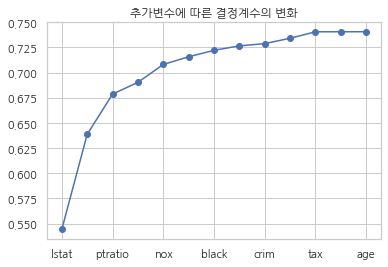

In [10]:
pd.Series(r2s, index=sel_ns).plot(marker="o", title="추가변수에 따른 결정계수의 변화")
plt.show()